In [3]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [8]:
# read dataset
df = pd.read_csv("ab_test_dataset.csv")
print(df.head())
print(df.describe())
print(df.groupby("group").sum("click"))

   user_id  click group                   timestamp
0        1      0   exp  2025-05-05 17:54:04.025048
1        2      1   exp  2025-04-29 10:13:23.025048
2        3      1   exp  2025-04-29 09:58:20.025048
3        4      1   exp  2025-05-11 13:55:54.025048
4        5      0   exp  2025-04-19 15:15:02.025048
            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.399800
std     5773.647028      0.489869
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000
         user_id  click
group                  
con    150005000   3072
exp     50005000   4924


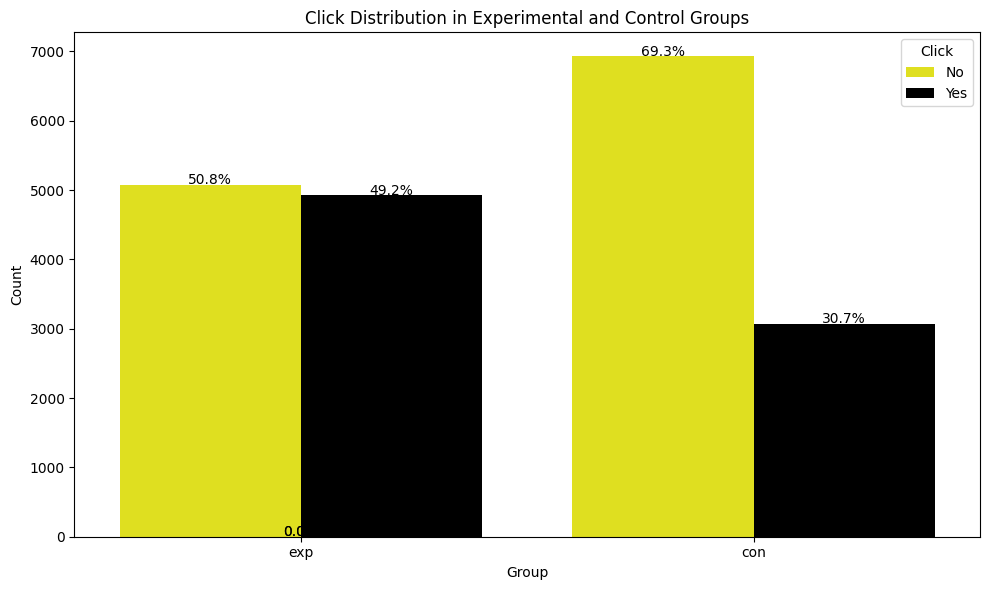

In [20]:
# a simple bar chart showing the total clicks versus no of clicks in each group can provide a clear visual comparison of user engagement

# custom color palette for yellow and black
palette = {0: 'yellow', 1: 'black'} # assuming 0 is for no click, 1 for click

# plotting the click distribution for each group with the custom colors
plt.figure(figsize=(10,6))
ax = sns.countplot(x='group', hue='click', data=df, palette=palette)
plt.title('Click Distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Click', labels=['No','Yes'])

# calculate the percentages and annotate the bars
group_counts = df.groupby('group').size()
# print(group_counts)
# group_click_counts = df.groupby('group', 'click').size().reset_index(name='count')

for p in ax.patches:
    height = p.get_height()
    # find the group and click type for the current bar
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}%', ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

## Parameters of the Model from Power Analysis
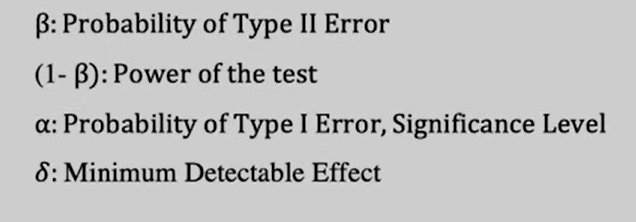


In [29]:
alpha = 0.05 # type 1 error. amount of error we are comfortable making when we reject the null hypotheis while the null hypothesis is actually true
delta = 0.1 # whether beside of having the statistical significance difference is large enough to say that we are comfortable making that business descion to making the new launch 
beta = 0.2 # amount of time we are failing to reject null hypothesis while null hypothsis should be rejected

In [46]:
# total number of clicks per each group
N_con = df[df['group']=='con'].count()[0]
N_exp = df[df['group']=='exp'].count()[0]
print(N_con,N_exp)
# calculating the total number of click per group by summing 1's
X_con = df.groupby('group')['click'].sum().loc['con']
X_exp = df.groupby('group')['click'].sum().loc['exp']
print(X_con,X_exp)

10000 10000
3072 4924


C:\Users\marsh\AppData\Local\Temp\ipykernel_17076\232245027.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  N_con = df[df['group']=='con'].count()[0]
C:\Users\marsh\AppData\Local\Temp\ipykernel_17076\232245027.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  N_exp = df[df['group']=='exp'].count()[0]


### Calculating pooled estimates for clicks per group

### Calculating total number of clicks per group by summing clicks
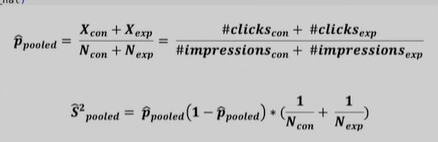

In [47]:
# computing the estimate of click probalibilty per group
p_con_hat = X_con / N_con
p_exp_hat = X_exp / N_exp

# computing the estimate of pooled clicked probability
p_pooled_hat = (X_con+X_exp)/(N_con+N_exp)

# computing the estimate of pooled variance
pooled_var = p_pooled_hat*(1-p_pooled_hat)*(1/N_con + 1/N_exp)

# computing the estimate SE
SE = np.sqrt(pooled_var)

print(SE)

0.006927625278549642


### Calculating Test Statistics
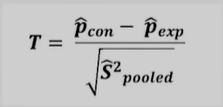

In [48]:
# computing test statistics of Z-test (since my sample size > 30 CLT)
test_stat = (p_con_hat - p_exp_hat)/SE

# critical value of the Z-test (alpha/2 becuase we have 2 sided 2 sample test)
Z_crit = norm.ppf(1-alpha/2)

### Calculating p_values of the Z_test
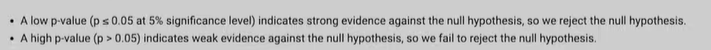
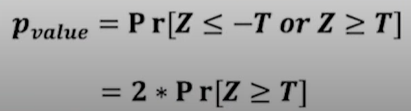

In [49]:
# calculating p value
p_value = 2* norm.sf(abs(test_stat))

In [50]:
# function checking the statistical significance
def is_statistical_sig(p_value, alpha):
    """
    We assess whether there is statistical significance on the p-value and alpha.

    Arguments:
    - p_value (float): The p-value resulting from a statical test.
    - alpha (float, optional): The significance level threshold used to determine statistical significance. Default is 0.05.

    Returns:
    - Prints the assessment of statistical significance.
    """
    # print the wounded p_value to 3 deciamls places
    print(round(p_value))

    # determine statistical significance
    if p_value <= alpha:
        print("There is statistical significance, indicating that the observed differeces between the groups are unlikely to have occured due to random chance.")
    else:
        print("There is no statistical significance, suggesting that the observed differeces between the groups could have occured by chance.")

is_statistical_sig(p_value, alpha)

0
There is statistical significance, indicating that the observed differeces between the groups are unlikely to have occured due to random chance.


<function matplotlib.pyplot.show(close=None, block=None)>

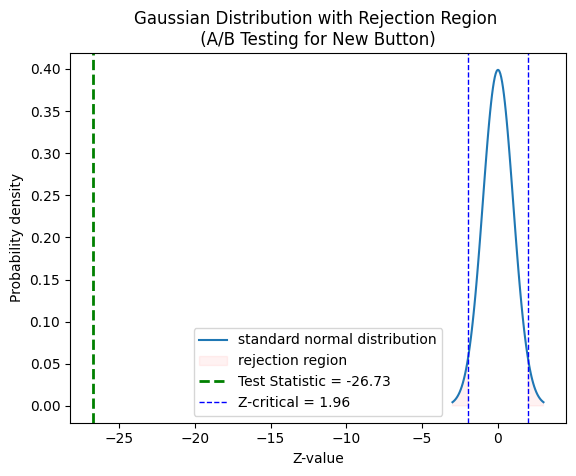

In [55]:
# paramters for the standrd normal distribution
mu=0
sigma = 1
x = np.linspace(mu - 3*sigma, mu + 3*sigma,100)
y = norm.pdf(x, mu, sigma)

# plotting the standard normal distribution
plt.plot(x,y,label='standard normal distribution')
#shade the rejection region for a two tailed test
plt.fill_between(x,y, where=(x > Z_crit) | (x < -Z_crit), color = 'red', alpha=0.05, label='rejection region')
# adding test statistics
plt.axvline(test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {test_stat:.2f}')
# adding Z-critical values
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=1)

# adding lables and title
plt.xlabel('Z-value')
plt.ylabel('Probability density')
plt.title('Gaussian Distribution with Rejection Region \n (A/B Testing for New Button) ')
plt.legend()

# show plot
plt.show

#### since test statistics (green) is much lower than the lower CI (rejection region) we can reject null hypothesis

### Calculating Confidence Interval for the test
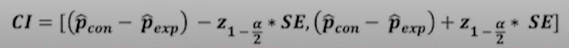

#### the narrower the CI is the higher the quality of the results, hence more generalizable.

In [57]:
# calculating the CI for a 2-sample Z-test
CI = [
    round((p_exp_hat - p_con_hat) - SE*Z_crit, 3), # lower
    round((p_exp_hat - p_con_hat) + SE*Z_crit, 3) # upper
]

### Testing for parctical significance in A/B testing

In [59]:
def is_practically_sig(delta, CI_95):
    """
    We assess here if the difference between control and experimental group is practically significant using the minimum detectable effect (delta)

    Arguments:
    - delta (flaot): the minimum detectable effect (MDE) considered for practical significance.
    - CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% CI.

    Returns:
    - Prints whether the experiment has parctical significance based on the MDE and CI.
    """

    # extract lower bound of 95% CI
    lower_bound_CI = CI_95[0]

    # check if the lower bound of the CI is greater than or equal to delta
    if lower_bound_CI >= delta:
        print(f"We have practical significance \nwith MDE of {delta}")
        return True
    else:
        print("We don't have practical significance \nthe difference between control and experimental group id not practically significant.")
        return False

# call the function
sig = is_practically_sig(delta, CI)
print(sig)

We have practical significance 
with MDE of 0.1
True
